In [63]:
import random
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, Resize, Compose, Grayscale

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
# load dataset

path_to_dataset = Path(os.getcwd()) / "dataset"
path_to_dataset.mkdir(exist_ok=True)

transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
  ]
)

data = datasets.Caltech101(root=path_to_dataset, 
                           download=True, 
                           transform=transforms)

Files already downloaded and verified


torch.Size([224, 224, 3])


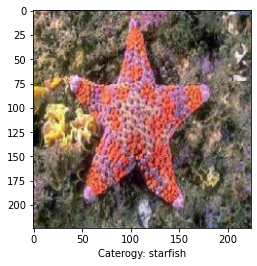

In [65]:
idx = random.randint(0, data.__len__()-1)
mapping = {i:j for i, j in enumerate(data.categories)} 
plt.imshow(data[idx][0].permute(1, 2, 0))
plt.xlabel(f"Caterogy: {mapping.get(data[idx][1])}");
print(data[idx][0].permute(1, 2, 0).shape)

In [74]:
def grayscale_to_rgb(image):
    # Assuming image is a grayscale image with shape (1, H, W)
    # Duplicate the single channel to create three channels.
    image_rgb = torch.cat([image, image, image], dim=0)
    return image_rgb

train_data, test_data = torch.utils.data.random_split(data, [.8, .2])

for x in train_data:
    if x[0].shape[0] == 1:
        x = 
  
# train_data = DataLoader(train_data, batch_size=16, shuffle=True)
# test_data = DataLoader(test_data, batch_size=16, shuffle=True)

3


In [41]:
class VGG11(nn.Module):
  def __init__(self, input_channels, out_channels):
    super(VGG11, self).__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(input_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      nn.Conv2d(256, 512, kernel_size=(3, 3), stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      nn.ReLU(inplace=True),
      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      nn.ReLU(inplace=True),
    )
    self.linear = nn.Sequential(
      nn.Linear(512*7*7, 4096),
      nn.Dropout(0.5),
      nn.Linear(4096, 4096),
      nn.Dropout(0.5),
      nn.Linear(4096, 101),
    )
    
  def forward(self, x):
    x = self.seq(x)
    # x = x.view(-1)
    x = torch.flatten(x, 1)
    x = self.linear(x)
    # print(x.shape)
    return x

In [53]:
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 64
vgg = VGG11(INPUT_CHANNELS, OUTPUT_CHANNELS).to(device)

In [58]:
lr = 10**-2
optimizer = optim.SGD(vgg.parameters(), lr=lr, momentum=0.9)
loss_function = nn.NLLLoss()

EPOCHS = 2

for epoch in (t:=trange(EPOCHS)):
  running_loss = 0.0
  for i, data in enumerate(train_data, 0):
    inputs, labels = data
    
    optimizer.zero_grad()
    
    outputs = vgg(inputs)
    
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  
    loss.item()
    
    t.set_description(f"Losses {(loss.item()):.4f}")

    break


  0%|          | 0/2 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [3, 224, 224] at entry 0 and [1, 224, 224] at entry 10